In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


In [44]:
from utils.subspace_clustering_helper_funcs import *
from utils.ae_eval_and_vis import *
from utils.ae_torch_classes import *
from utils.preprocessing import *
from utils.ml_pipeline import *

# Load in Data

In [3]:
# remove pID 101 because it doesn't exist
# remove pID 131 because it  doesnt have enough user defined gestures
# each participant has 100 experimenter defined files and 50 user defined files
# 10 experimenter defined gestures and 5 user defined gestures

file_types = ["IMU_extract", "movavg_files"]
expt_types = ["experimenter-defined"]

#remove participant 131 because they are missing gestures 
pIDs_impaired = ['P102','P103','P104','P105','P106','P107','P108','P109','P110','P111',
       'P112','P114','P115','P116','P118','P119','P121','P122','P123','P124','P125',
       'P126','P127','P128', 'P132']
# remove participants P001 and P003 because they dont have duplicate or open gestures
pIDs_unimpaired = ['P004','P005','P006','P008','P010','P011']

pIDs_both = pIDs_impaired + pIDs_unimpaired

In [4]:
# Kai's laptop
data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\Filtered_Datasets\\"
# BRC Desktop
#data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\"

print("Loading")

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']
metadata_cols_df = pd.read_pickle('C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\metadata_cols_df.pkl')

full_emg_XY_df = pd.read_pickle(data_path+'metadata_EMG_allgestures_allusers.pkl')


Loading


In [5]:
print(full_emg_XY_df.shape)
full_emg_XY_df.head()

(427008, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,0.000002,0.000002,0.000001,0.000002,0.000003,0.000004,0.000002,0.000002,0.000003,0.000020,0.000004,0.000004,0.000002,0.000009,0.000001,0.000002
1,P102,pan,1,0.000002,0.000002,0.000001,0.000002,0.000003,0.000005,0.000003,0.000003,0.000003,0.000014,0.000007,0.000007,0.000002,0.000017,0.000001,0.000002
2,P102,pan,1,0.000002,0.000002,0.000001,0.000002,0.000004,0.000005,0.000003,0.000003,0.000004,0.000007,0.000004,0.000005,0.000003,0.000020,0.000003,0.000002
3,P102,pan,1,0.000002,0.000002,0.000002,0.000002,0.000005,0.000006,0.000003,0.000003,0.000006,0.000005,0.000004,0.000003,0.000004,0.000015,0.000003,0.000003
4,P102,pan,1,0.000003,0.000002,0.000002,0.000002,0.000005,0.000007,0.000003,0.000002,0.000008,0.000003,0.000007,0.000022,0.000004,0.000017,0.000002,0.000003


Data preprocessing
1. Standard Scaler (Mean subtraction and sets std to 1)
    - Required for models that assume the data is centered at zero, such as linear models / SVMs
3. Min Max Scaler (normalizes data to be within the range 0 to 1)
    - Better for neural networks (because of their activation functions)

In [6]:
print("Started")
start_time = time.time()

preprocessing_approach = 'MinMaxScaler'
full_emg_ppd_XY_df = preprocess_df_by_gesture(full_emg_XY_df, preprocessing_approach)

print(f"Completed in {time.time() - start_time}s")

Started
Completed in 78.42637729644775s


Need to do the train test split...

In [7]:
# Held out useres from NB 003
held_out_user_pids = ['P103','P109','P114','P124','P128','P004','P010']

In [8]:
print(full_emg_ppd_XY_df.shape)
full_emg_ppd_XY_df.head()

(427008, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,0.051097,0.000000,0.044487,0.000427,0.245732,0.132152,0.084929,0.243845,0.000000,0.219090,0.145465,0.017872,0.000000,0.000000,0.000000,0.116603
1,P102,pan,1,0.061510,0.011574,0.044980,0.069719,0.328052,0.213999,0.223501,0.735062,0.022070,0.144152,0.387271,0.123884,0.144105,0.532267,0.047537,0.247359
2,P102,pan,1,0.034272,0.017179,0.030284,0.188315,0.501220,0.257289,0.276336,0.850666,0.078724,0.049598,0.168567,0.061954,0.216238,0.674256,0.714861,0.350993
3,P102,pan,1,0.047327,0.015914,0.052514,0.209151,0.693083,0.361226,0.285125,0.698345,0.172053,0.027661,0.149688,0.007699,0.383104,0.390241,0.813279,0.813632
4,P102,pan,1,0.160123,0.017753,0.117863,0.194238,0.741528,0.406699,0.335756,0.531881,0.328194,0.001471,0.336175,0.639682,0.386275,0.532156,0.273336,0.748913


In [9]:
test_users_df = full_emg_ppd_XY_df[full_emg_ppd_XY_df['Participant'].isin(held_out_user_pids)]

print(test_users_df.shape)
test_users_df.head()

(99648, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
11520,P103,gesture-1,1,0.000000,0.008856,0.015885,0.208230,0.013135,0.000000,0.070232,0.200759,0.000648,0.007461,0.003780,0.002578,0.003470,0.005523,0.314168,0.086658
11521,P103,gesture-1,1,0.006557,0.014960,0.016004,0.157272,0.003703,0.020062,0.118512,0.097361,0.001758,0.017904,0.006779,0.002440,0.002087,0.009145,0.204870,0.116757
11522,P103,gesture-1,1,0.004954,0.015069,0.003858,0.130019,0.008820,0.029740,0.000000,0.121722,0.000918,0.018769,0.008072,0.003237,0.000000,0.006741,0.047290,0.134363
11523,P103,gesture-1,1,0.007458,0.010218,0.015384,0.179068,0.013738,0.054213,0.126174,0.022921,0.000000,0.003932,0.008093,0.008706,0.000490,0.006196,0.338627,0.142885
11524,P103,gesture-1,1,0.008470,0.003977,0.000000,0.194660,0.006334,0.040319,0.095151,0.052132,0.000774,0.002674,0.011127,0.007675,0.004694,0.004975,0.276880,0.107900


In [10]:
# Merge the DataFrames with an indicator
merged_df = full_emg_ppd_XY_df.merge(test_users_df, how='left', indicator=True)
# Filter out the rows that are in both DataFrames
training_users_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns='_merge')

print(training_users_df.shape)
training_users_df.head()

(327360, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,0.051097,0.000000,0.044487,0.000427,0.245732,0.132152,0.084929,0.243845,0.000000,0.219090,0.145465,0.017872,0.000000,0.000000,0.000000,0.116603
1,P102,pan,1,0.061510,0.011574,0.044980,0.069719,0.328052,0.213999,0.223501,0.735062,0.022070,0.144152,0.387271,0.123884,0.144105,0.532267,0.047537,0.247359
2,P102,pan,1,0.034272,0.017179,0.030284,0.188315,0.501220,0.257289,0.276336,0.850666,0.078724,0.049598,0.168567,0.061954,0.216238,0.674256,0.714861,0.350993
3,P102,pan,1,0.047327,0.015914,0.052514,0.209151,0.693083,0.361226,0.285125,0.698345,0.172053,0.027661,0.149688,0.007699,0.383104,0.390241,0.813279,0.813632
4,P102,pan,1,0.160123,0.017753,0.117863,0.194238,0.741528,0.406699,0.335756,0.531881,0.328194,0.001471,0.336175,0.639682,0.386275,0.532156,0.273336,0.748913


Now can break it up into data and labels

In [11]:
emg_gesture_train_labels_df = training_users_df['Gesture_ID']
emg_gesture_test_labels_df = test_users_df['Gesture_ID']
emg_user_train_labels_df = training_users_df['Participant']
emg_user_test_labels_df = test_users_df['Participant']
emg_training_users_df = training_users_df.drop(metadata_cols, axis=1)
emg_test_users_df = test_users_df.drop(metadata_cols, axis=1)

Checking the data and plotting a few of the input space channels:

In [12]:
print(emg_training_users_df.shape)
emg_training_users_df.head()

(327360, 16)


,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,0.051097,0.000000,0.044487,0.000427,0.245732,0.132152,0.084929,0.243845,0.000000,0.219090,0.145465,0.017872,0.000000,0.000000,0.000000,0.116603
1,0.061510,0.011574,0.044980,0.069719,0.328052,0.213999,0.223501,0.735062,0.022070,0.144152,0.387271,0.123884,0.144105,0.532267,0.047537,0.247359
2,0.034272,0.017179,0.030284,0.188315,0.501220,0.257289,0.276336,0.850666,0.078724,0.049598,0.168567,0.061954,0.216238,0.674256,0.714861,0.350993
3,0.047327,0.015914,0.052514,0.209151,0.693083,0.361226,0.285125,0.698345,0.172053,0.027661,0.149688,0.007699,0.383104,0.390241,0.813279,0.813632
4,0.160123,0.017753,0.117863,0.194238,0.741528,0.406699,0.335756,0.531881,0.328194,0.001471,0.336175,0.639682,0.386275,0.532156,0.273336,0.748913


In [13]:
seq_len = 64
num_gestures = emg_training_users_df.shape[0]//seq_len
sample_data = emg_training_users_df.to_numpy().reshape(num_gestures, seq_len, -1)
print(sample_data.shape)

(5115, 64, 16)


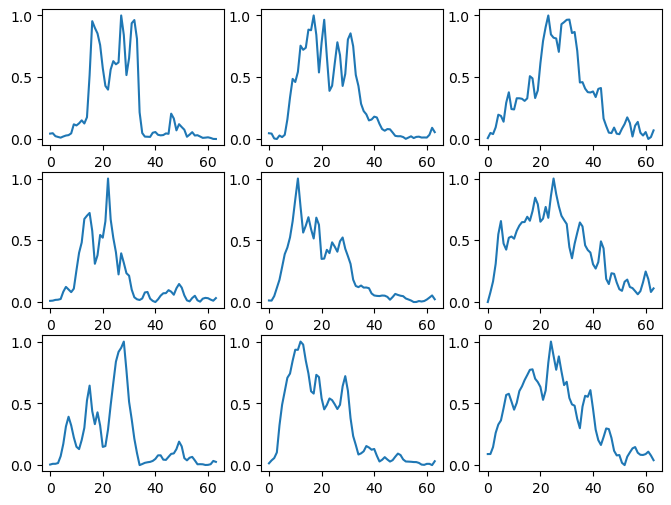

In [15]:
selected_gestures = [1,2,3]
selected_channels = [1,2,3]
figure_size = (8,6)

fig, axes = plt.subplots(len(selected_gestures), len(selected_channels), figsize=figure_size)
    
for i, gesture in enumerate(selected_gestures):
    for j, channel in enumerate(selected_channels):
        original = sample_data[gesture, :, channel]
        
        axes[i, j].plot(original)
        
        #axes[i, j].set_title(f'Gesture {gesture}, Channel {channel}')
        #if i == 0 and j == 0:
        #    axes[i, j].legend()

In [16]:
print(emg_gesture_train_labels_df.shape)
emg_gesture_train_labels_df.head()

(327360,)


0    pan
1    pan
2    pan
3    pan
4    pan
Name: Gesture_ID, dtype: object

In [17]:
print(emg_training_users_df.shape)
emg_training_users_df.head()

(327360, 16)


,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,0.051097,0.000000,0.044487,0.000427,0.245732,0.132152,0.084929,0.243845,0.000000,0.219090,0.145465,0.017872,0.000000,0.000000,0.000000,0.116603
1,0.061510,0.011574,0.044980,0.069719,0.328052,0.213999,0.223501,0.735062,0.022070,0.144152,0.387271,0.123884,0.144105,0.532267,0.047537,0.247359
2,0.034272,0.017179,0.030284,0.188315,0.501220,0.257289,0.276336,0.850666,0.078724,0.049598,0.168567,0.061954,0.216238,0.674256,0.714861,0.350993
3,0.047327,0.015914,0.052514,0.209151,0.693083,0.361226,0.285125,0.698345,0.172053,0.027661,0.149688,0.007699,0.383104,0.390241,0.813279,0.813632
4,0.160123,0.017753,0.117863,0.194238,0.741528,0.406699,0.335756,0.531881,0.328194,0.001471,0.336175,0.639682,0.386275,0.532156,0.273336,0.748913


In [18]:
print(emg_gesture_test_labels_df.shape)
emg_gesture_test_labels_df.head()

(99648,)


11520    gesture-1
11521    gesture-1
11522    gesture-1
11523    gesture-1
11524    gesture-1
Name: Gesture_ID, dtype: object

In [19]:
print(emg_test_users_df.shape)
emg_test_users_df.head()

(99648, 16)


,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
11520,0.000000,0.008856,0.015885,0.208230,0.013135,0.000000,0.070232,0.200759,0.000648,0.007461,0.003780,0.002578,0.003470,0.005523,0.314168,0.086658
11521,0.006557,0.014960,0.016004,0.157272,0.003703,0.020062,0.118512,0.097361,0.001758,0.017904,0.006779,0.002440,0.002087,0.009145,0.204870,0.116757
11522,0.004954,0.015069,0.003858,0.130019,0.008820,0.029740,0.000000,0.121722,0.000918,0.018769,0.008072,0.003237,0.000000,0.006741,0.047290,0.134363
11523,0.007458,0.010218,0.015384,0.179068,0.013738,0.054213,0.126174,0.022921,0.000000,0.003932,0.008093,0.008706,0.000490,0.006196,0.338627,0.142885
11524,0.008470,0.003977,0.000000,0.194660,0.006334,0.040319,0.095151,0.052132,0.000774,0.002674,0.011127,0.007675,0.004694,0.004975,0.276880,0.107900


Set up dataloaders for the AEs

In [20]:
num_rows_per_gesture = 64 # From the interp
batch_size = 32  # Adjust batch size as needed

In [21]:
emg_train_loader = create_dataloader(emg_training_users_df, GestureDatasetAE)
emg_test_loader = create_dataloader(emg_test_users_df, GestureDatasetAE)

In [22]:
# Create an iterator from the DataLoader
train_loader_iter = iter(emg_train_loader)
# Get the first batch
first_batch = next(train_loader_iter)
data = first_batch

print("Data type:", type(data))
print("Data shape:", data.shape)

Data type: <class 'torch.Tensor'>
Data shape: torch.Size([32, 64, 16])


In [23]:
# Create an iterator from the DataLoader
test_loader_iter = iter(emg_test_loader)
# Get the first batch
first_batch = next(test_loader_iter)
data = first_batch

print("Data type:", type(data))
print("Data shape:", data.shape)

Data type: <class 'torch.Tensor'>
Data shape: torch.Size([32, 64, 16])


Now finally train some AEs (just basic RNN AEs for now)

In [24]:
# Kai:
model_dir_path = 'C:\\Users\\kdmen\\Desktop\\Research\\Repos\\fl-gestures\\models\\'
# BRC:
#model_dir_path = 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\'

input_dim = 16
seq_len = 64
criterion = nn.MSELoss()
num_epochs = 10

Started
Epoch 0: Train Loss: 0.0744478931184858;  Validation Loss: 0.04953467009627089
Epoch 1: Train Loss: 0.042824078863486645;  Validation Loss: 0.03718943186864561
Epoch 2: Train Loss: 0.035124602867290376;  Validation Loss: 0.031673782334035755
Epoch 3: Train Loss: 0.02982779956655577;  Validation Loss: 0.02735179381407037
Epoch 4: Train Loss: 0.02725637910189107;  Validation Loss: 0.02618698692139314
Epoch 5: Train Loss: 0.02639642161084339;  Validation Loss: 0.02559021016468807
Epoch 6: Train Loss: 0.025809140189085155;  Validation Loss: 0.025102521806043023
Epoch 7: Train Loss: 0.02424448055680841;  Validation Loss: 0.022920228578910535
Epoch 8: Train Loss: 0.022844262514263393;  Validation Loss: 0.02246207310533037
Epoch 9: Train Loss: 0.022543990903068335;  Validation Loss: 0.022301018238067627


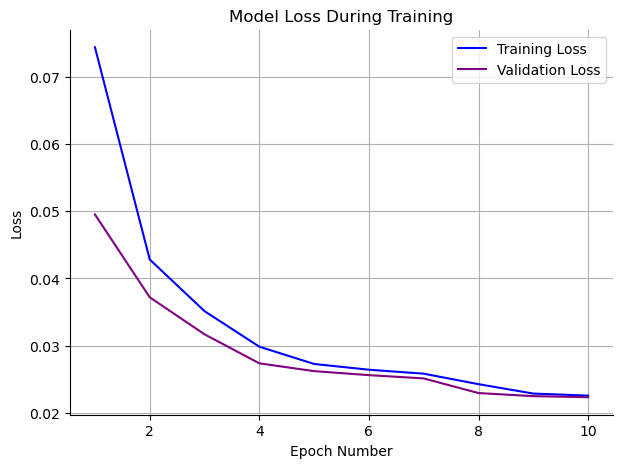

In [25]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [20, 10]
model_20_10mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.08014776648487895;  Validation Loss: 0.05982140390848627
Epoch 1: Train Loss: 0.056241032248362896;  Validation Loss: 0.054050439398507684
Epoch 2: Train Loss: 0.050865832972340284;  Validation Loss: 0.048653750091182946
Epoch 3: Train Loss: 0.04865996513981372;  Validation Loss: 0.047677364352406285
Epoch 4: Train Loss: 0.0482574742520228;  Validation Loss: 0.04734359476335195
Epoch 5: Train Loss: 0.04813113533891737;  Validation Loss: 0.04729709637408354
Epoch 6: Train Loss: 0.04807450883090496;  Validation Loss: 0.04712702295913988
Epoch 7: Train Loss: 0.04802995042409748;  Validation Loss: 0.047273366655014
Epoch 8: Train Loss: 0.04800955932587385;  Validation Loss: 0.04725633865716506
Epoch 9: Train Loss: 0.04799082884564996;  Validation Loss: 0.04720369179029854


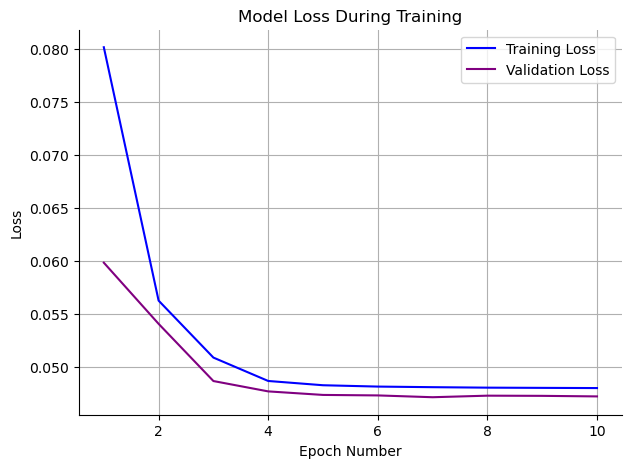

In [26]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [20, 10, 3]
model_20_10_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.09094888719264418;  Validation Loss: 0.062044386428837875
Epoch 1: Train Loss: 0.05521290975157171;  Validation Loss: 0.04895372004533301
Epoch 2: Train Loss: 0.04651174854952842;  Validation Loss: 0.042710491589137485
Epoch 3: Train Loss: 0.041273454274050894;  Validation Loss: 0.037773232450898815
Epoch 4: Train Loss: 0.03613446436356753;  Validation Loss: 0.03263809444496826
Epoch 5: Train Loss: 0.032613721466623245;  Validation Loss: 0.03051602026941825
Epoch 6: Train Loss: 0.030692709155846386;  Validation Loss: 0.028347822818524982
Epoch 7: Train Loss: 0.027707111707422884;  Validation Loss: 0.02579722412842877
Epoch 8: Train Loss: 0.024973111285362393;  Validation Loss: 0.023616528746728996
Epoch 9: Train Loss: 0.023760956758633257;  Validation Loss: 0.023056569604241118


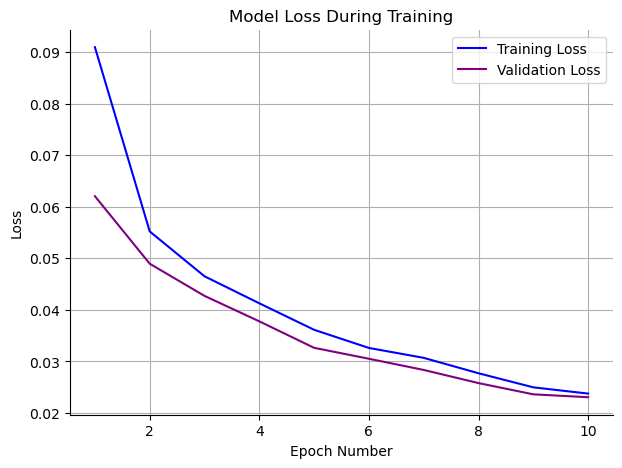

In [27]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [12, 10]
model_12_10mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.10793249942362308;  Validation Loss: 0.06268022429882264
Epoch 1: Train Loss: 0.05498695459682494;  Validation Loss: 0.04890767196003271
Epoch 2: Train Loss: 0.04573978302069008;  Validation Loss: 0.04192485097719698
Epoch 3: Train Loss: 0.040096732205711305;  Validation Loss: 0.03685804806193527
Epoch 4: Train Loss: 0.03544444590806961;  Validation Loss: 0.03279675855016222
Epoch 5: Train Loss: 0.031780814123339954;  Validation Loss: 0.030009167002780095
Epoch 6: Train Loss: 0.029447067563887687;  Validation Loss: 0.028436229621269266
Epoch 7: Train Loss: 0.02800766455475241;  Validation Loss: 0.027136017473376527
Epoch 8: Train Loss: 0.026517704455181958;  Validation Loss: 0.025358256142662496
Epoch 9: Train Loss: 0.024267297168262304;  Validation Loss: 0.022867828531532873


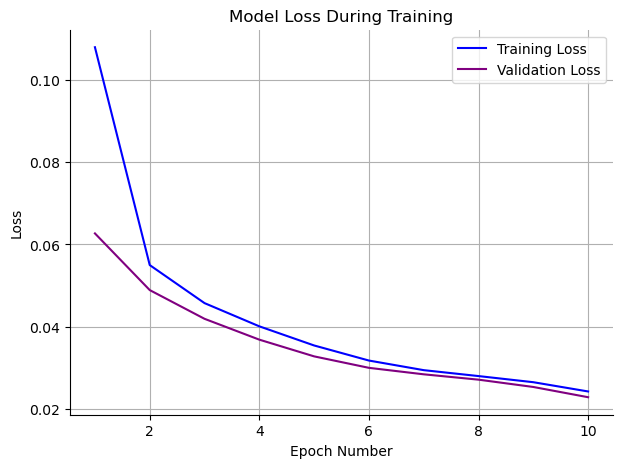

In [28]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [10]
model_10mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.0961967839160934;  Validation Loss: 0.05551698978762237
Epoch 1: Train Loss: 0.05192894374486059;  Validation Loss: 0.048947805348707706
Epoch 2: Train Loss: 0.04608247254509479;  Validation Loss: 0.043060241077019244
Epoch 3: Train Loss: 0.041931582940742375;  Validation Loss: 0.04003235180767215
Epoch 4: Train Loss: 0.038645787793211636;  Validation Loss: 0.03622927395056705
Epoch 5: Train Loss: 0.03586201639845967;  Validation Loss: 0.03468066256265251
Epoch 6: Train Loss: 0.034562699333764615;  Validation Loss: 0.03312917570678555
Epoch 7: Train Loss: 0.031943721091374756;  Validation Loss: 0.03045325422165345
Epoch 8: Train Loss: 0.03041082015261054;  Validation Loss: 0.029267124717636983
Epoch 9: Train Loss: 0.02804492712020874;  Validation Loss: 0.027104662199105536


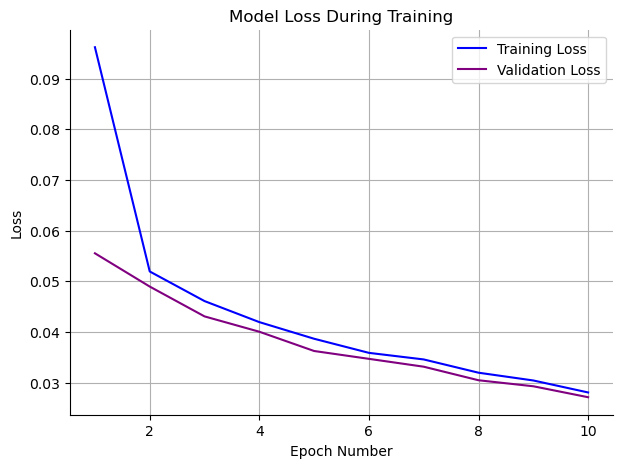

In [29]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [12, 8]
model_12_8mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.1293966388795525;  Validation Loss: 0.07023941725492477
Epoch 1: Train Loss: 0.06298795009497553;  Validation Loss: 0.05745338108770701
Epoch 2: Train Loss: 0.05429084645584226;  Validation Loss: 0.05088043174877459
Epoch 3: Train Loss: 0.0490787293529138;  Validation Loss: 0.04628023170695013
Epoch 4: Train Loss: 0.04534062470775098;  Validation Loss: 0.04273730090686253
Epoch 5: Train Loss: 0.04201425849460065;  Validation Loss: 0.03944330183523042
Epoch 6: Train Loss: 0.03914123654831201;  Validation Loss: 0.03721535852064892
Epoch 7: Train Loss: 0.037345892703160646;  Validation Loss: 0.0356133403826733
Epoch 8: Train Loss: 0.03561485095415264;  Validation Loss: 0.03375304604367334
Epoch 9: Train Loss: 0.03316601281985641;  Validation Loss: 0.031125720742405678


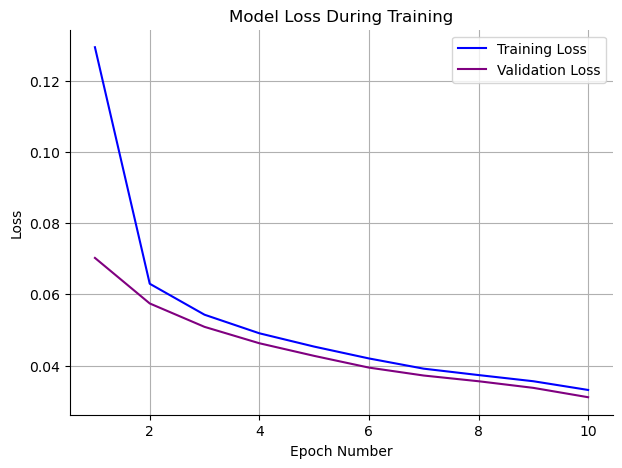

In [30]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [8]
model_8mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.08721852037124336;  Validation Loss: 0.06175583274084694
Epoch 1: Train Loss: 0.05632451514247805;  Validation Loss: 0.05139561902199473
Epoch 2: Train Loss: 0.046966475900262594;  Validation Loss: 0.04320930742791721
Epoch 3: Train Loss: 0.041733188647776844;  Validation Loss: 0.039836685496325394
Epoch 4: Train Loss: 0.039757796586491166;  Validation Loss: 0.03808934788922874
Epoch 5: Train Loss: 0.03840639677364379;  Validation Loss: 0.036551718200956075
Epoch 6: Train Loss: 0.03579699625261128;  Validation Loss: 0.03376009117583839
Epoch 7: Train Loss: 0.034228229359723625;  Validation Loss: 0.033271500194559295
Epoch 8: Train Loss: 0.03374761804006994;  Validation Loss: 0.03308370640995551
Epoch 9: Train Loss: 0.033291076822206375;  Validation Loss: 0.03240447829724574


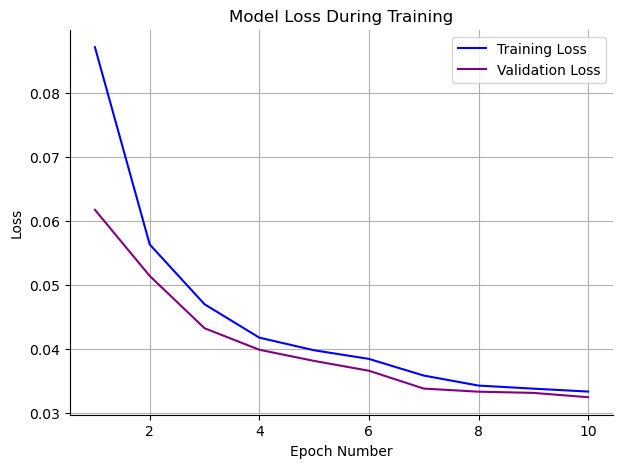

In [31]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [12, 6]
model_12_6mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.12508274633437394;  Validation Loss: 0.06924145425460776
Epoch 1: Train Loss: 0.062215241906233135;  Validation Loss: 0.05754773364383347
Epoch 2: Train Loss: 0.0545681121526286;  Validation Loss: 0.051937922303165705
Epoch 3: Train Loss: 0.05046044166665524;  Validation Loss: 0.04870982034778108
Epoch 4: Train Loss: 0.04768828703090548;  Validation Loss: 0.04581563874166839
Epoch 5: Train Loss: 0.044597666268236934;  Validation Loss: 0.0421456192829171
Epoch 6: Train Loss: 0.04089302225038409;  Validation Loss: 0.03870564007333347
Epoch 7: Train Loss: 0.03796342508867383;  Validation Loss: 0.03646963165730846
Epoch 8: Train Loss: 0.03638960130047053;  Validation Loss: 0.03538807025369333
Epoch 9: Train Loss: 0.0355612519197166;  Validation Loss: 0.03459670987664437


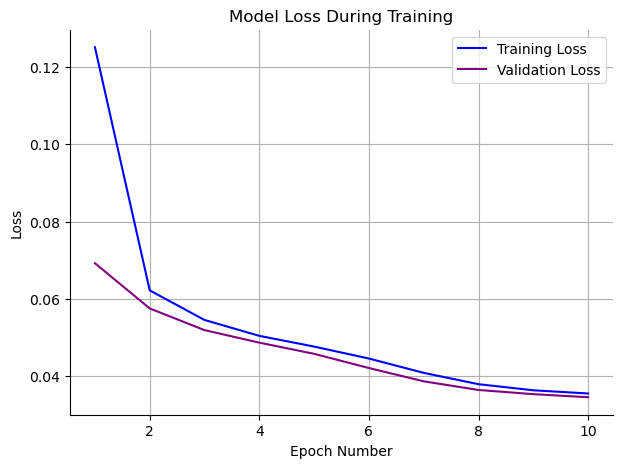

In [32]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [6]
model_6mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.08971075103618205;  Validation Loss: 0.07491075718889431
Epoch 1: Train Loss: 0.0638674521818757;  Validation Loss: 0.05856399891936049
Epoch 2: Train Loss: 0.05690186265856027;  Validation Loss: 0.05508029042762153
Epoch 3: Train Loss: 0.05278427333105355;  Validation Loss: 0.05011288357936606
Epoch 4: Train Loss: 0.04934757025912404;  Validation Loss: 0.04825803972020441
Epoch 5: Train Loss: 0.048544598184525965;  Validation Loss: 0.04764300387124626
Epoch 6: Train Loss: 0.04829502119682729;  Validation Loss: 0.04743980920436431
Epoch 7: Train Loss: 0.04814329911023378;  Validation Loss: 0.047300264087258556
Epoch 8: Train Loss: 0.04778301902115345;  Validation Loss: 0.046134832562232504
Epoch 9: Train Loss: 0.044979229709133504;  Validation Loss: 0.042381503752299717


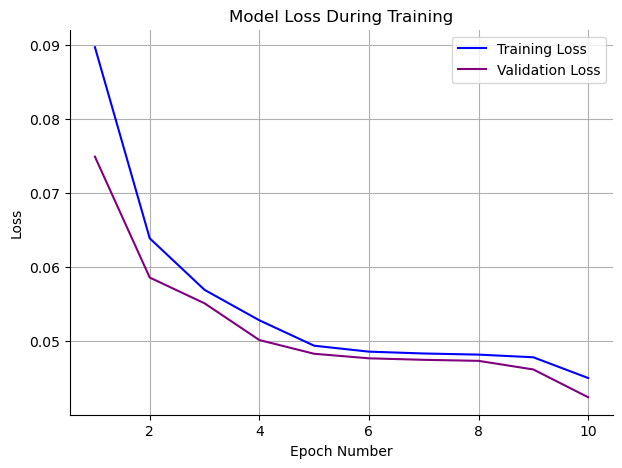

In [33]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [12, 7, 3]
model_12_7_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.11716841836459935;  Validation Loss: 0.06721421559246218
Epoch 1: Train Loss: 0.058614441123791036;  Validation Loss: 0.05483809562057865
Epoch 2: Train Loss: 0.052205346245318654;  Validation Loss: 0.049199760796464216
Epoch 3: Train Loss: 0.04739058061968535;  Validation Loss: 0.04548777974381739
Epoch 4: Train Loss: 0.044589732913300394;  Validation Loss: 0.04309100817356791
Epoch 5: Train Loss: 0.04303340276237577;  Validation Loss: 0.04179401269980839
Epoch 6: Train Loss: 0.04224368962459266;  Validation Loss: 0.041119364755494256
Epoch 7: Train Loss: 0.041891126544214785;  Validation Loss: 0.04080366023949215
Epoch 8: Train Loss: 0.04170562874060124;  Validation Loss: 0.040528617799282074
Epoch 9: Train Loss: 0.041584673523902896;  Validation Loss: 0.040508625154592554


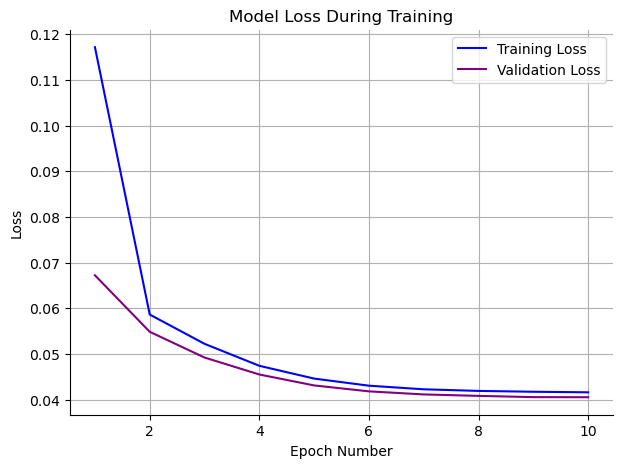

In [34]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [12, 3]
model_12_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.14032932557165623;  Validation Loss: 0.10672317232404437
Epoch 1: Train Loss: 0.08336659609340132;  Validation Loss: 0.07582977733441762
Epoch 2: Train Loss: 0.06863328935578465;  Validation Loss: 0.06781191758963527
Epoch 3: Train Loss: 0.06371644597966224;  Validation Loss: 0.06305094793134806
Epoch 4: Train Loss: 0.06003211482893676;  Validation Loss: 0.059327734976398705
Epoch 5: Train Loss: 0.05725763223599643;  Validation Loss: 0.0565852805667994
Epoch 6: Train Loss: 0.055112129426561296;  Validation Loss: 0.05442047514477555
Epoch 7: Train Loss: 0.05331428765784949;  Validation Loss: 0.05255217135560756
Epoch 8: Train Loss: 0.05171931723598391;  Validation Loss: 0.050953369435607174
Epoch 9: Train Loss: 0.05017720989417285;  Validation Loss: 0.0493458019075345


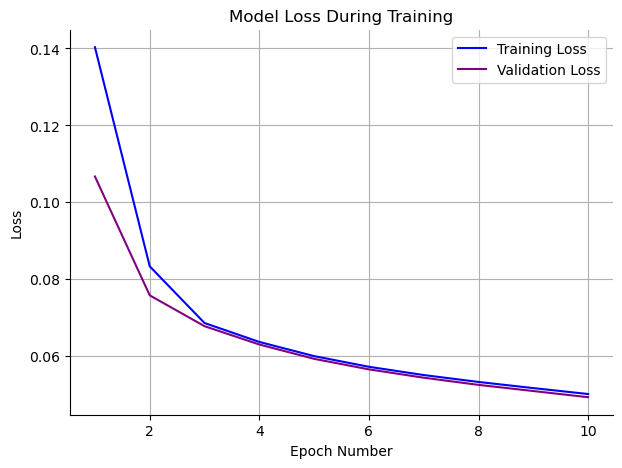

In [35]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [3]
model_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

## Visual Inspection of Reconstructed VS Original Signals

Average testing loss across the entire test_loader: 0.047202252155664016


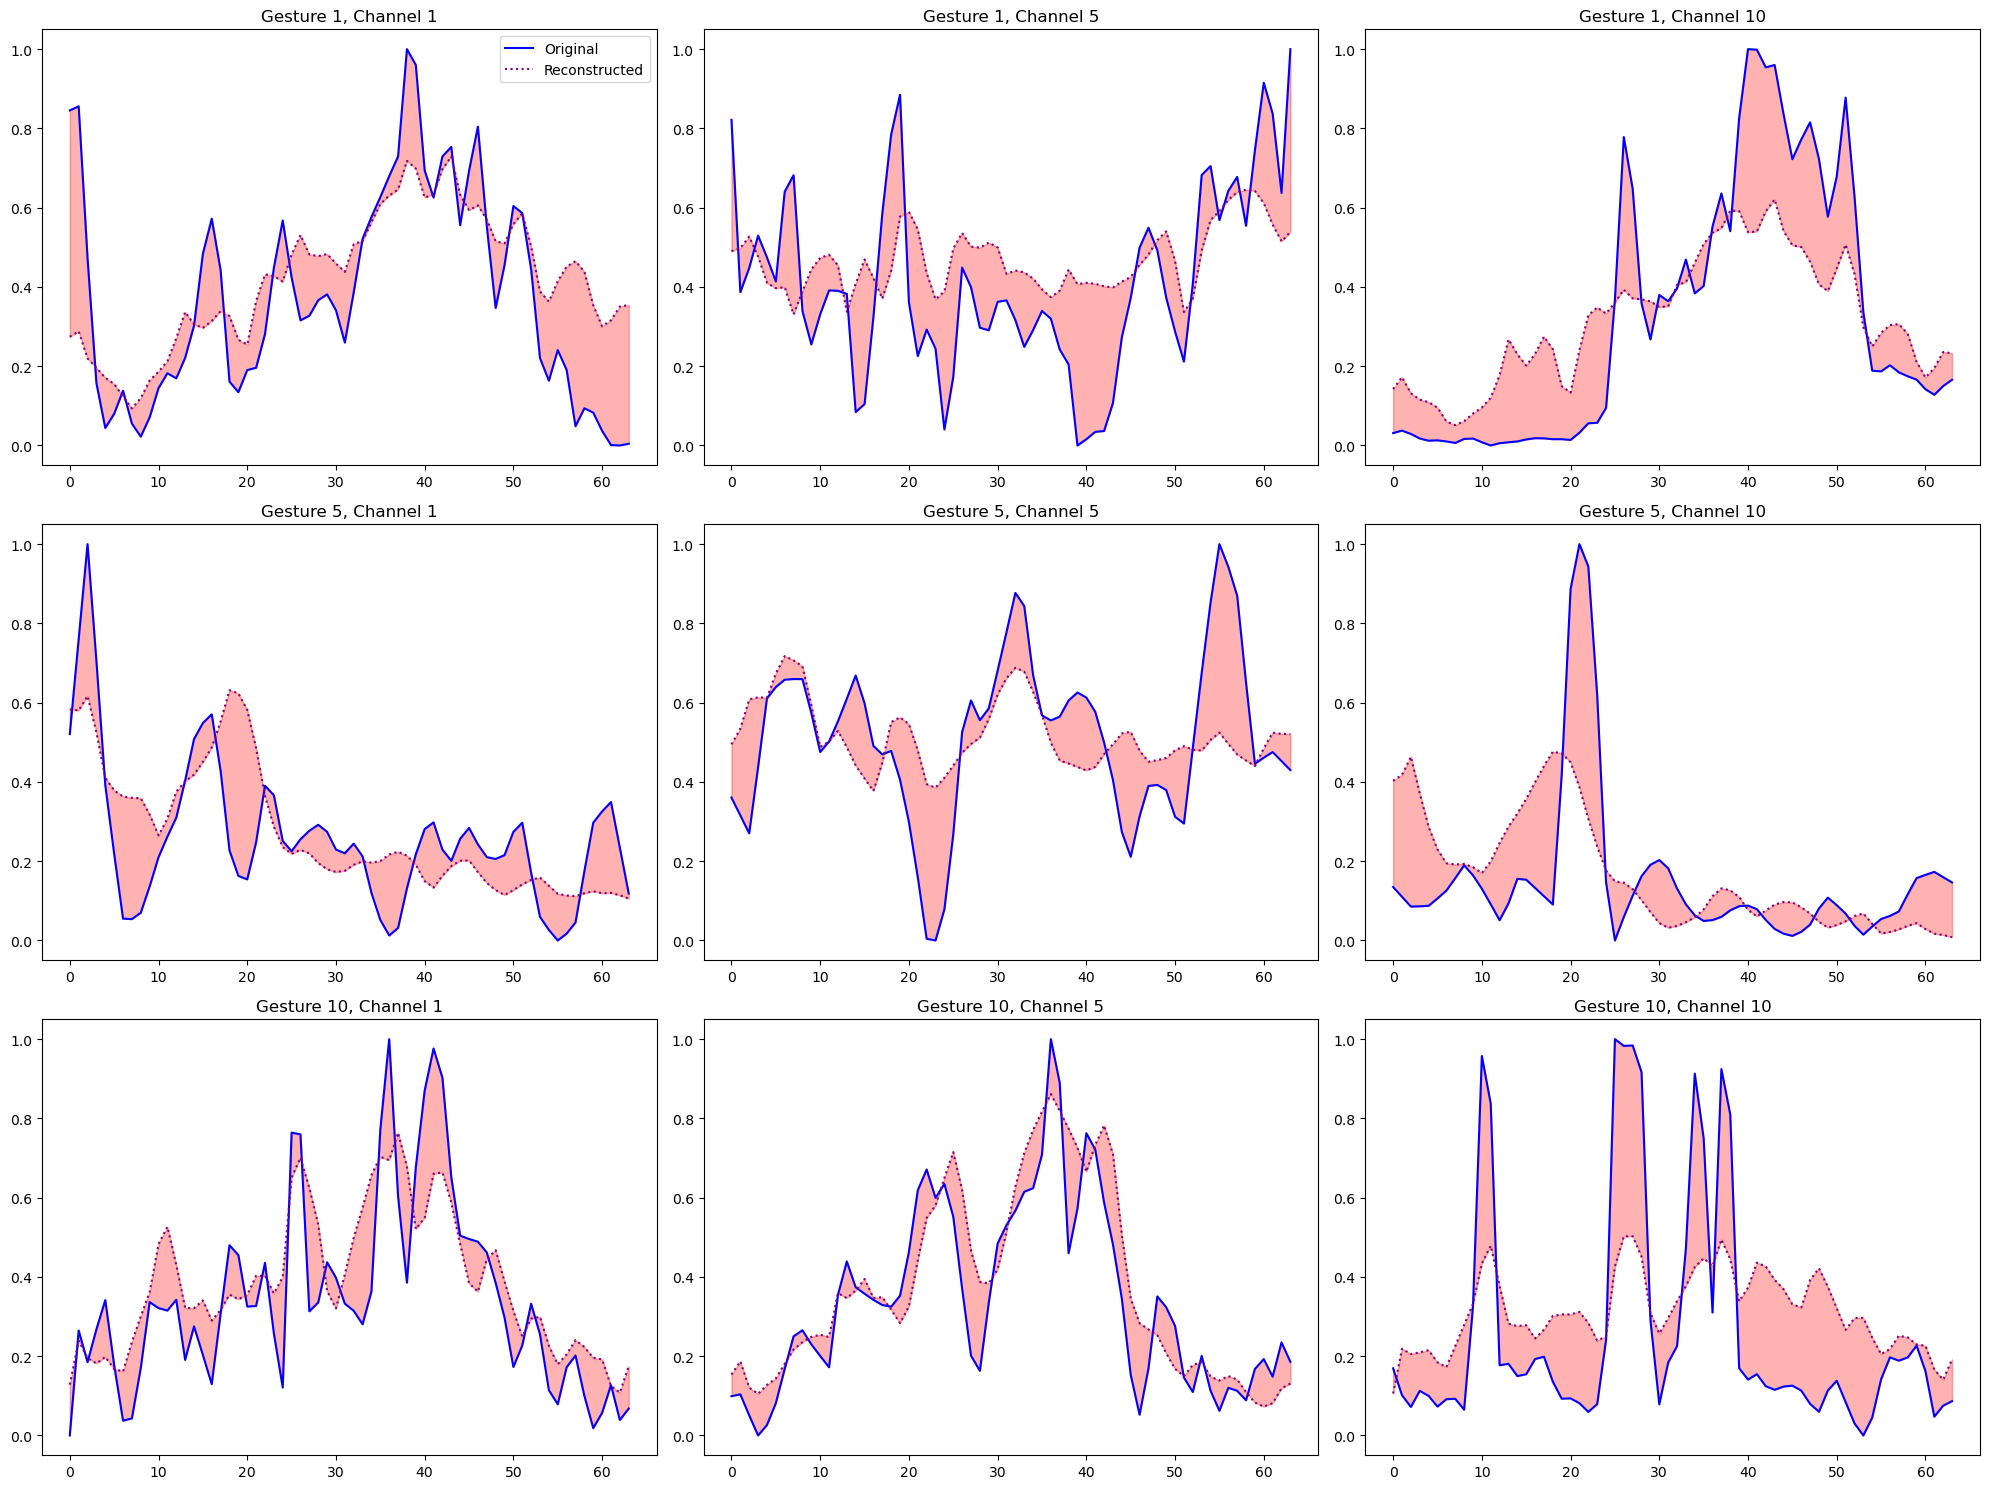

In [38]:
my_model = model_20_10_3mir

average_test_loss, sample_data_lst, reconstructions_lst, latent_representations_lst = eval_on_testset_and_return_original_and_reconstructed(my_model, emg_test_loader)
visualize_original_vs_reconstructed_gestures(sample_data_lst[0], reconstructions_lst[0], selected_gestures=[1, 5, 10], selected_channels=[1, 5, 10])
#latent_space_vis(latent_representations_lst)

Average testing loss across the entire test_loader: 0.022272740585767493


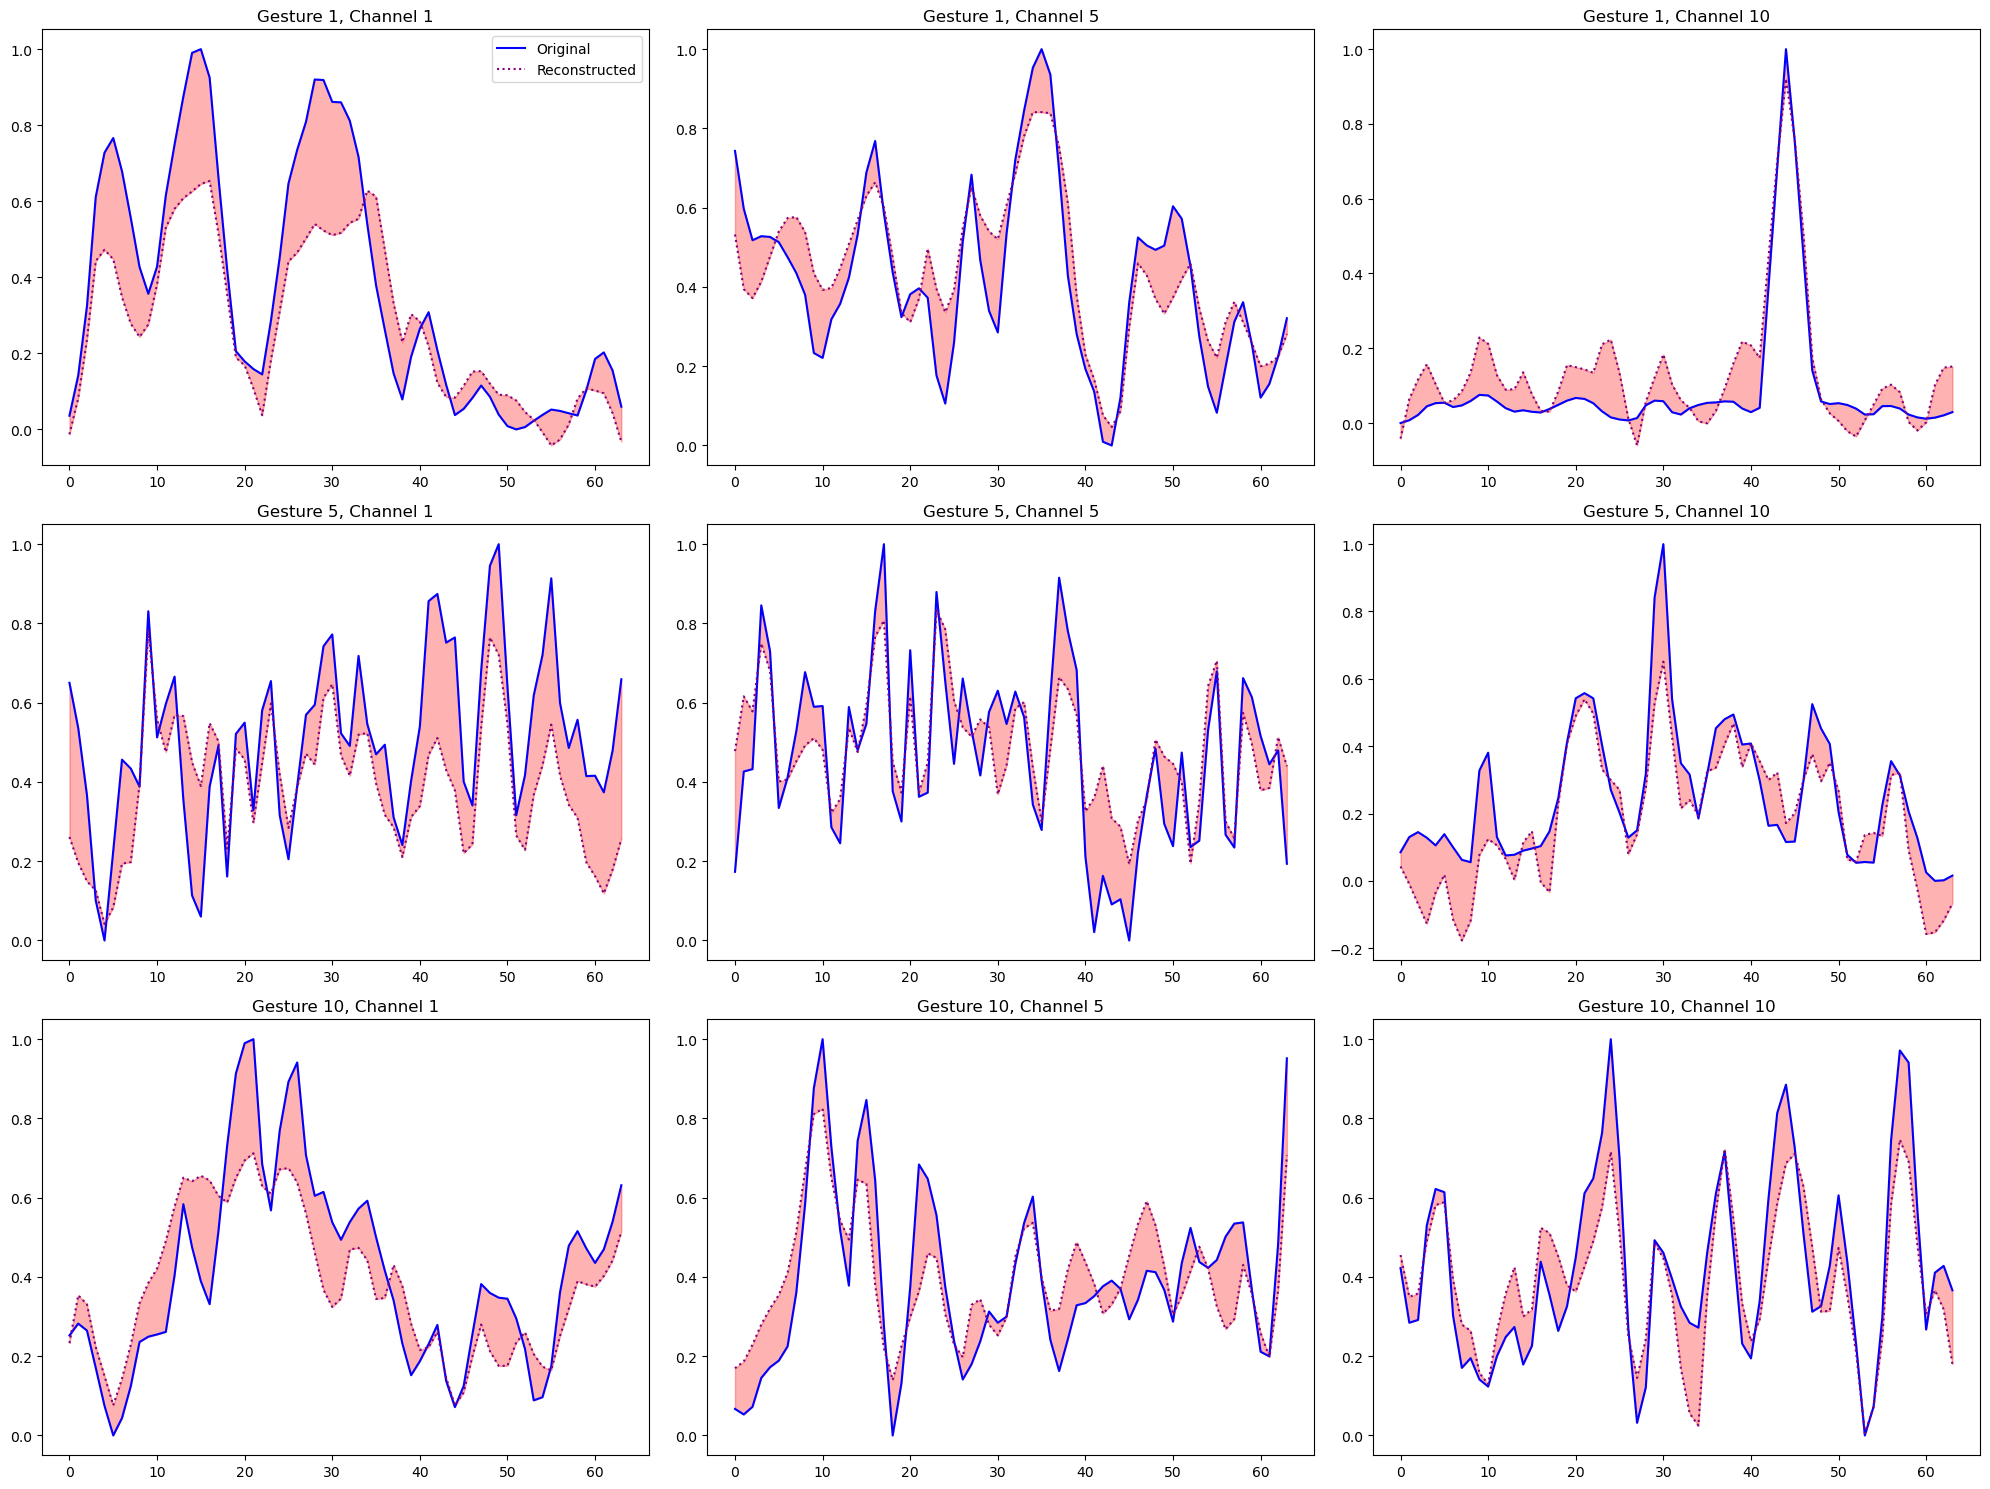

In [39]:
my_model = model_20_10mir

average_test_loss, sample_data_lst, reconstructions_lst, latent_representations_lst = eval_on_testset_and_return_original_and_reconstructed(my_model, emg_test_loader)
visualize_original_vs_reconstructed_gestures(sample_data_lst[0], reconstructions_lst[0], selected_gestures=[1, 5, 10], selected_channels=[1, 5, 10])
#latent_space_vis(latent_representations_lst)

Using the bottom one since the reconstructions appear to be better (plus it had lower val loss)

In [40]:
len(latent_representations_lst)

latent_representations = np.concatenate(latent_representations_lst)
print(latent_representations.shape)

# Reshape to 2D since TSNE and such can't handle 3D inputs...
latent_20_10_EMG = latent_representations.reshape(latent_representations.shape[0], -1)
print(latent_20_10_EMG.shape)

(1557, 64, 10)
(1557, 640)


## Latent Space Clustering

In [42]:
# Maximum number of components
max_clusters = 12
num_clusters_range = list(range(2, max_clusters+1))

In [46]:
import warnings
warnings.filterwarnings('ignore')
# C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning warnings.warn(

In [47]:
km_silhouette_lst=[]
km_davies_bouldin_lst=[]
km_cali_har_lst=[]
km_dunn_index_lst=[]
km_gap_stat_lst=[]
for n in num_clusters_range:
    print(f"{n}/{num_clusters_range[-1]}")
    silhouette, db_index, ch_index, di_index, gap_stat = run_clustering_algorithm('KMeans', latent_20_10_EMG, num_clusters=n)
    km_silhouette_lst.append(silhouette)
    km_davies_bouldin_lst.append(db_index)
    km_cali_har_lst.append(ch_index)
    km_dunn_index_lst.append(di_index)
    km_gap_stat_lst.append(gap_stat)

2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
12/12


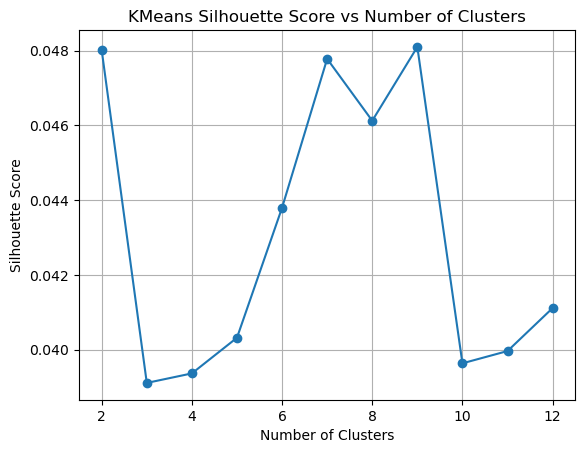

In [48]:
plt.plot(num_clusters_range, km_silhouette_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('KMeans Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

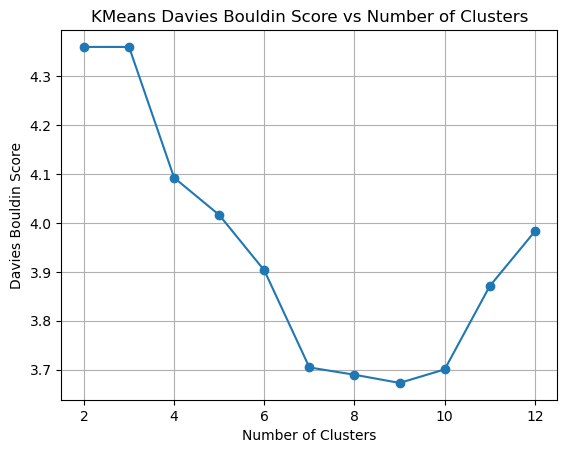

In [49]:
plt.plot(num_clusters_range, km_davies_bouldin_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies Bouldin Score')
plt.title('KMeans Davies Bouldin Score vs Number of Clusters')
plt.grid(True)
plt.show()

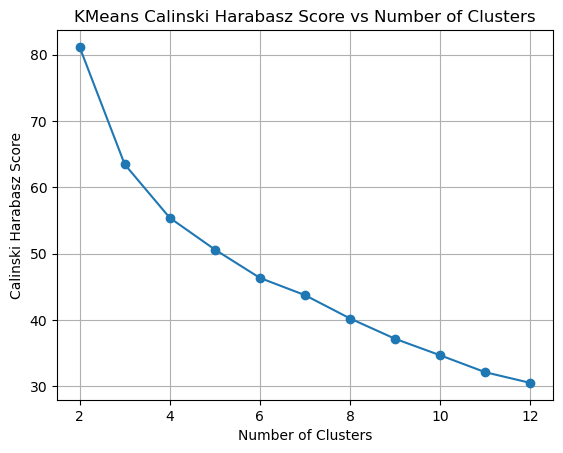

In [50]:
plt.plot(num_clusters_range, km_cali_har_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.title('KMeans Calinski Harabasz Score vs Number of Clusters')
plt.grid(True)
plt.show()

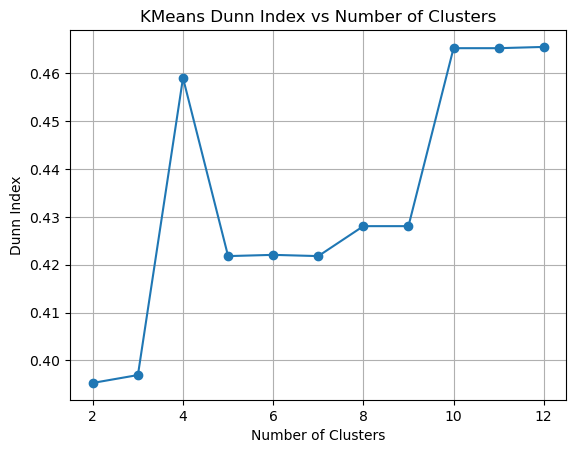

In [51]:
plt.plot(num_clusters_range, km_dunn_index_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Dunn Index')
plt.title('KMeans Dunn Index vs Number of Clusters')
plt.grid(True)
plt.show()

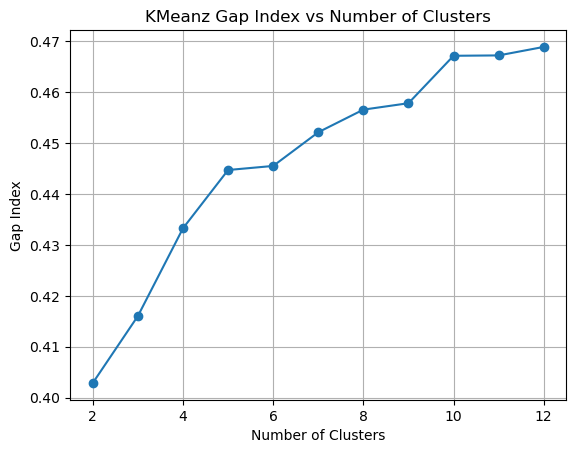

In [52]:
plt.plot(num_clusters_range, km_gap_stat_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Gap Index')
plt.title('KMeanz Gap Index vs Number of Clusters')
plt.grid(True)
plt.show()

Chosen number of optimal clusters to use for KNN (and other methods):

## Gesture Classification